 <b> <font size="6"> PA006: Credit Card Dataset for Clustering </font></b>

# Imports

In [1]:
import pandas as pd
import numpy as np
import inflection
from IPython.core.display  import HTML
from sklearn import metrics as mt
from sklearn import preprocessing as pp

# EDA
from pandas_profiling import ProfileReport
import sweetviz as sv

# visualization
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# Models
from sklearn import ensemble as en
from sklearn import cluster as cl
from sklearn import mixture as mx
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import ExtraTreesClassifier

# Reducers
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA as kpca
from sklearn               import manifold as mn
import umap.umap_ as umap

# Silhouette Visualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

from sklearn.preprocessing import normalize

## Helper Functions

In [285]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 25
    
    display(HTML( '<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
            
    sns.set()
    
def spider_plot(data, title):
    means = data.groupby('clusters').mean().to_numpy()
    names = data.columns[0:-1]
    label_loc = np.linspace(0,2*np.pi,len(data.columns[0:-1]), endpoint=False)
    #categories = np.arange(0, len(means))
    #categories = data['clusters'].unique()
    categories = np.sort(data['clusters'].unique())[::1]
    plt.figure(figsize=(10,10))
    plt.subplot(polar=True)
    for i in range(len(means)):
        plt.plot(label_loc, means[i], label=f'Cluster {categories[i]}')
    plt.title(f'Feature comparison\n {title}\n', size=15)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=names)
    plt.legend()
    plt.show()

In [3]:
jupyter_settings ()

Populating the interactive namespace from numpy and matplotlib


## Loading data

In [4]:
df_raw = pd.read_csv('../data/raw/CCGENERAL.csv')

# Data Description

In [5]:
df01 = df_raw.copy()

## Columns Rename

In [6]:
old_cols = df01.columns

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, old_cols))

#rename
df01.columns = cols_new

## Data Dimensions

In [7]:
print ('Number of rows: {}'.format(df01.shape[0]))
print ('Number os columns:{}'.format(df01.shape[1]))

Number of rows: 8950
Number os columns:18


## Data Types

In [8]:
df01.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## Check Missing Values

In [9]:
df01.isna().sum() / df01.shape[0] * 100

cust_id                             0.000000
balance                             0.000000
balance_frequency                   0.000000
purchases                           0.000000
oneoff_purchases                    0.000000
installments_purchases              0.000000
cash_advance                        0.000000
purchases_frequency                 0.000000
oneoff_purchases_frequency          0.000000
purchases_installments_frequency    0.000000
cash_advance_frequency              0.000000
cash_advance_trx                    0.000000
purchases_trx                       0.000000
credit_limit                        0.011173
payments                            0.000000
minimum_payments                    3.497207
prc_full_payment                    0.000000
tenure                              0.000000
dtype: float64

## Replace Missing Values

In [10]:
df01['minimum_payments'].fillna((0), inplace=True)
df01['credit_limit'].fillna((df01['credit_limit'].mean()), inplace=True)

In [11]:
df01.isna().sum()

cust_id                             0
balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
dtype: int64

In [12]:
df01.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## Descriptive Statistics

In [13]:
num_attributes = df01.select_dtypes(include = ['float64', 'int64'])
cat_attributes = df01.select_dtypes(exclude = ['float64', 'int64', 'datetime64[ns]'])

### Numerical Attributes

In [14]:
# estimadores de localicação
est1 = pd.DataFrame(num_attributes.apply(np.mean)).T
est2 = pd.DataFrame(num_attributes.apply(np.median)).T
est3 = pd.DataFrame(num_attributes.apply(np.min)).T
est4 = pd.DataFrame(num_attributes.apply(np.max)).T

# estimadores de variabilidade
est5 = pd.DataFrame(num_attributes.apply(np.std)).T
est6 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T

# skewness and kurtosis
est7 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
est8 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T

# conatenate
m1 = pd.concat([est3, est4, est6, est1, est2, est5, est7, est8]).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std deviation', 'skewness', 'kurtosis']
m1

# percentis
quartis = num_attributes.apply( lambda x: np.quantile( x, q=[0.10, 0.25, 0.50, 0.75, 0.95, 0.99])).T.reset_index()
quartis.columns = ['attributes', 'P10', 'P25', 'P50', 'P75', 'P95', 'P99']

#
m2 = pd.merge(m1, quartis, how='inner', on='attributes')
m2

,attributes,min,max,range,mean,median,std deviation,skewness,kurtosis,P10,P25,P50,P75,P95,P99
0,balance,0.0,19043.13856,19043.13856,1564.474828,873.385231,2081.415590,2.393386,7.674751,23.575529,128.281915,873.385231,2054.140036,5909.111808,9338.804814
1,balance_frequency,0.0,1.00000,1.00000,0.877271,1.000000,0.236891,-2.023266,3.092370,0.454545,0.888889,1.000000,1.000000,1.000000,1.000000
2,purchases,0.0,49039.57000,49039.57000,1003.204834,361.280000,2136.515413,8.144269,111.388771,0.000000,39.635000,361.280000,1110.130000,3998.619500,8977.290000
3,oneoff_purchases,0.0,40761.25000,40761.25000,592.437371,38.000000,1659.795184,10.045083,164.187572,0.000000,0.000000,38.000000,577.405000,2671.094000,6689.898200
4,installments_purchases,0.0,22500.00000,22500.00000,411.067645,89.000000,904.287592,7.299120,96.575178,0.000000,0.000000,89.000000,468.637500,1750.087500,3886.240500
5,cash_advance,0.0,47137.21176,47137.21176,978.871112,0.000000,2097.046713,5.166609,52.899434,0.000000,0.000000,0.000000,1113.821139,4647.169122,9588.163357
6,purchases_frequency,0.0,1.00000,1.00000,0.490351,0.500000,0.401348,0.060164,-1.638631,0.000000,0.083333,0.500000,0.916667,1.000000,1.000000
7,oneoff_purchases_frequency,0.0,1.00000,1.00000,0.202458,0.083333,0.298319,1.535613,1.161846,0.000000,0.000000,0.083333,0.300000,1.000000,1.000000
8,purchases_installments_frequency,0.0,1.00000,1.00000,0.364437,0.166667,0.397426,0.509201,-1.398632,0.000000,0.000000,0.166667,0.750000,1.000000,1.000000
9,cash_advance_frequency,0.0,1.50000,1.50000,0.135144,0.000000,0.200110,1.828686,3.334734,0.000000,0.000000,0.000000,0.222222,0.583333,0.833333


# Data Filtering

In [15]:
df02 = df01.copy()

# Feature Engineering

In [16]:
df03 = df02.copy()

In [17]:
df03.columns

Index(['cust_id', 'balance', 'balance_frequency', 'purchases',
       'oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment', 'tenure'],
      dtype='object')

In [18]:
df03['amount_full_payments'] = df03['payments'] * df03['prc_full_payment']
df03['amount_min_payments'] = df03['payments'] - df03['amount_full_payments']
df03['cash_advantage_mean'] = df03.apply(lambda x: x['cash_advance'] / x['cash_advance_trx'] if x['cash_advance_trx'] != 0 else 0, axis = 1 )
df03['purchases_mean'] = df03.apply(lambda x: x['purchases'] / x['purchases_trx'] if x['purchases_trx'] != 0 else 0, axis = 1  )

# Exploratory Data Analysis

## Univariate Analysis

In [19]:
df04 = df03.copy()

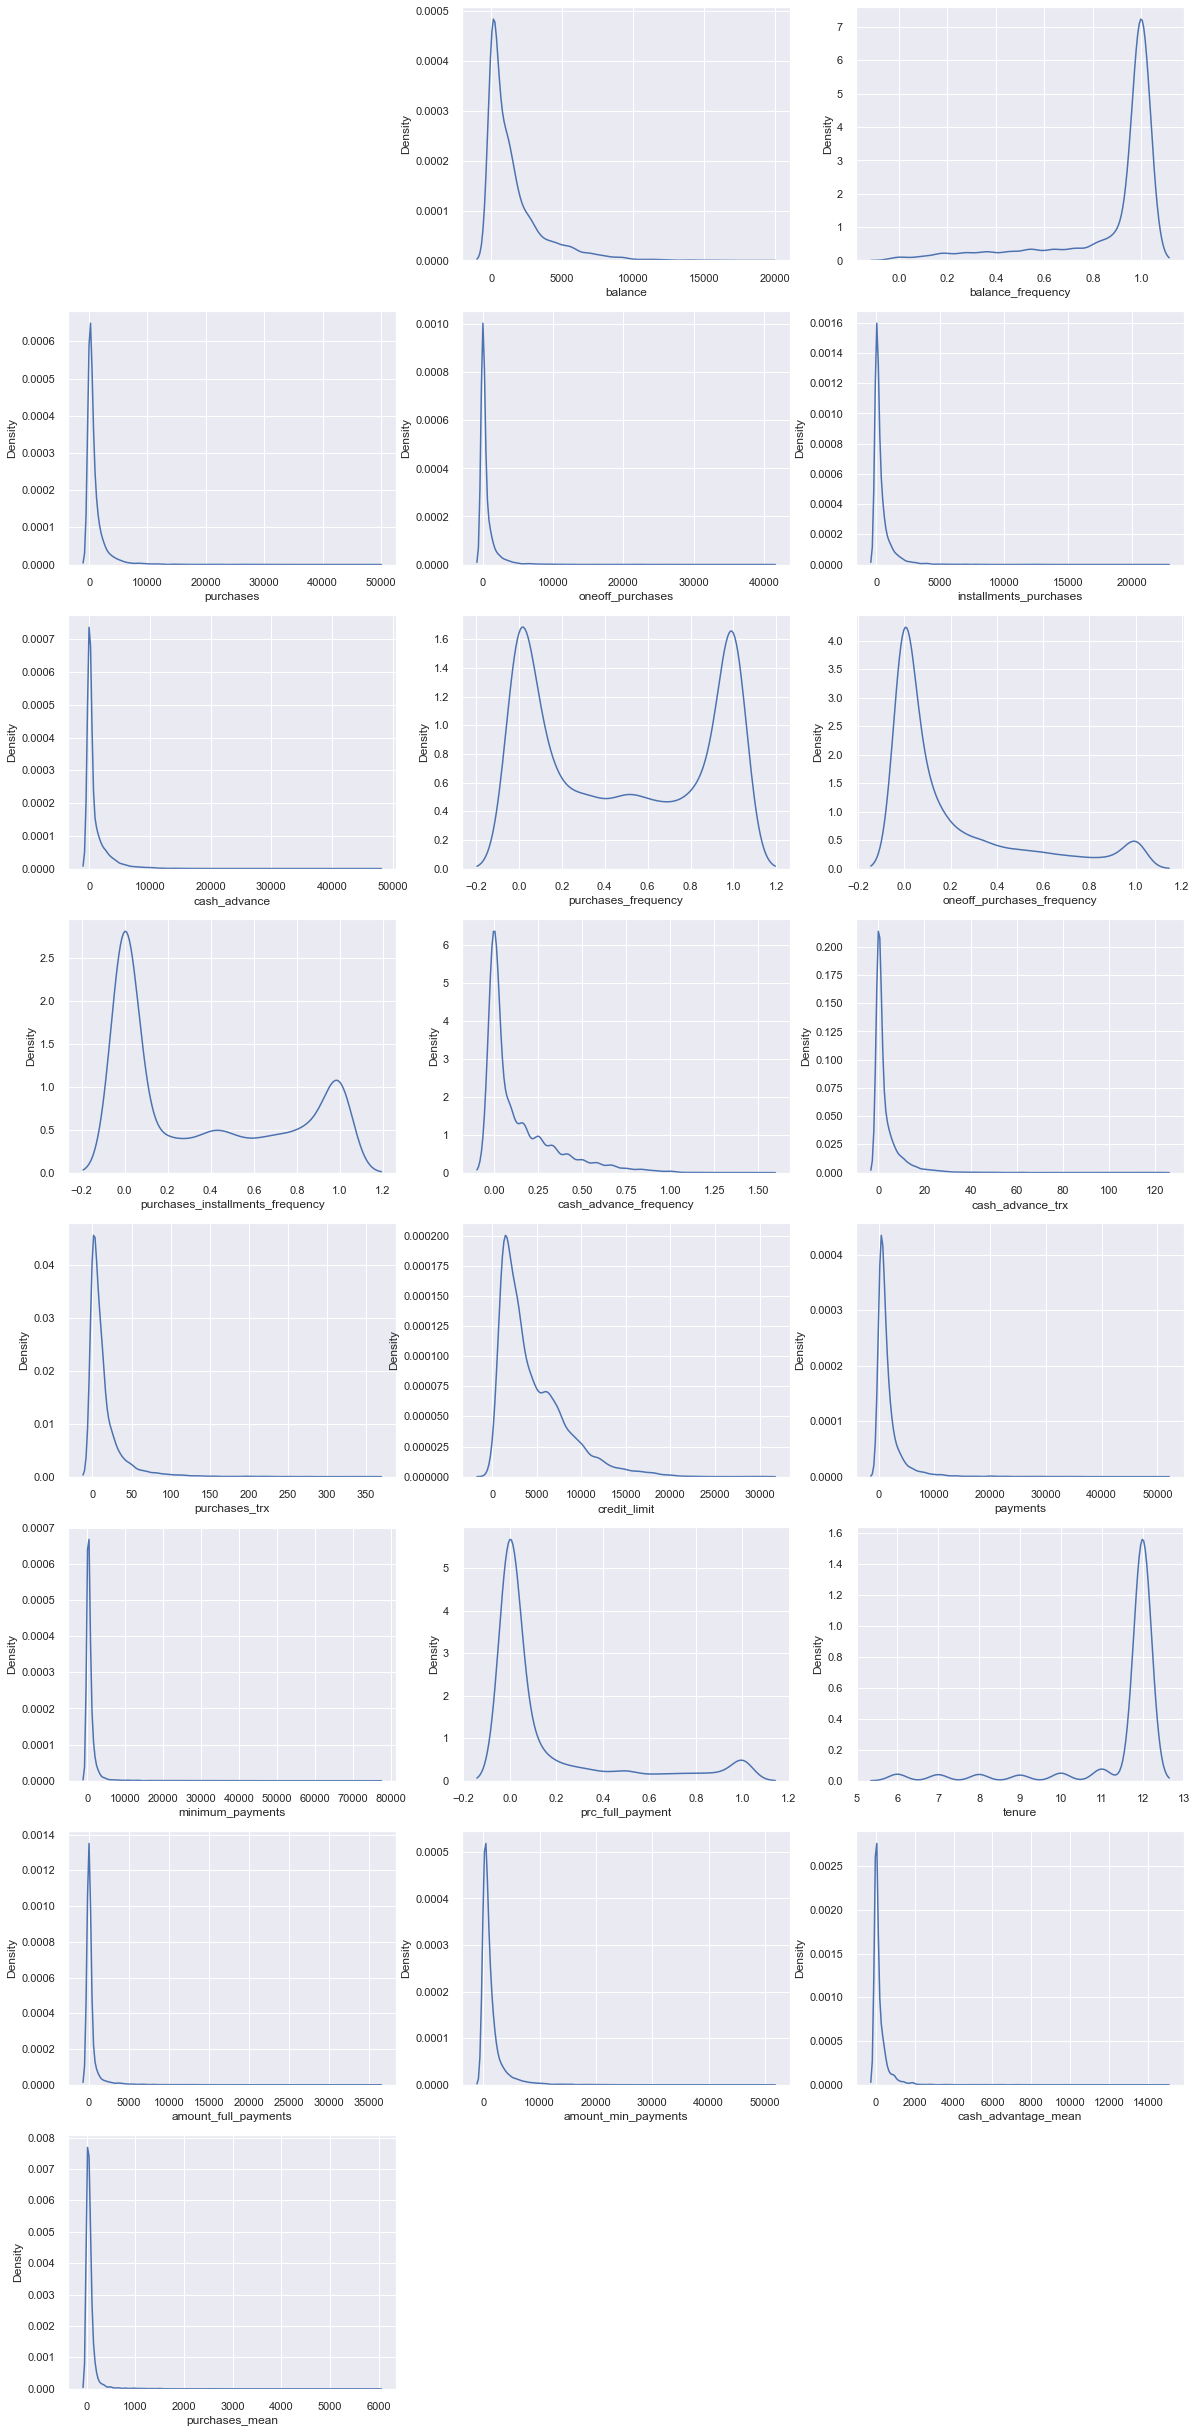

In [20]:
plt.figure(figsize=(20,55))
col = df04.columns
for i, col in enumerate(df03.columns):
    if df04[col].dtype != 'object':
        ax = plt.subplot(10, 3, i+1)
        sns.kdeplot(df04[col], ax=ax)
        plt.xlabel(col)
        
plt.show()

### Pandas Profiling

In [21]:
#profile = ProfileReport(df04, title = 'Credit Card Dataset for Clustering')
#profile.to_file("../reports/profiling_report.html")

### SweetViz

In [22]:
#analysis = sv.analyze(df04)
#analysis.show_html("../reports/sweetviz_report.html")

### Notes

* balance
    * 75% das clientes possuem saldo disponivel para compras até $ 2.500
    
    
* balance_frequency
    * a frequencia de atualização do saldo disponivel para compas é alto
    
    
* purchases
    * 22% dos clientes nao fizeram compras nos ultimos 6 meses
    
    
* oneoff_purchases
    * 48% dos clientes os ultimos 6 meses nao fizeram um one off purchases
    
    
* installments_purchases
    * 75% dos usam essa modalidade para compras ate $ 500, no entanto 43% nao realizaram compras nessa modalidade
    

* cash_advance
    * 51% dos clientes nao utilizaram essa modalidade
    * exite um cliente que utilizou 47 mil desta modalidade (123 trx)


* purchases_frequency
    * 22% dos clientes nao fizeram compras nos ultimos 6 meses


* oneoff_purchases_frequency
    * 48% dos clientes os ultimos 6 meses nao fizeram um one off purchases
    * alta correlação com oneoff_purchases


* purchases_installments_frequency
    * 43% nao realizaram compras nessa modalidade
    * alta correlação com installments_purchases


* cash_advance_frequency
 * 51% dos clientes nao utilizaram essa modalidade
 * alta correlação com cash_advance


* cash_advance_trx ->


* purchases_trx ->


* credit_limit ->


* payments ->


* minimum_payments ->


* prc_full_payment ->


* tenure ->

## Bivariate Analysis

In [23]:
#sns.pairplot(df04.drop(columns = 'cust_id'))

## Multivariate Analysis

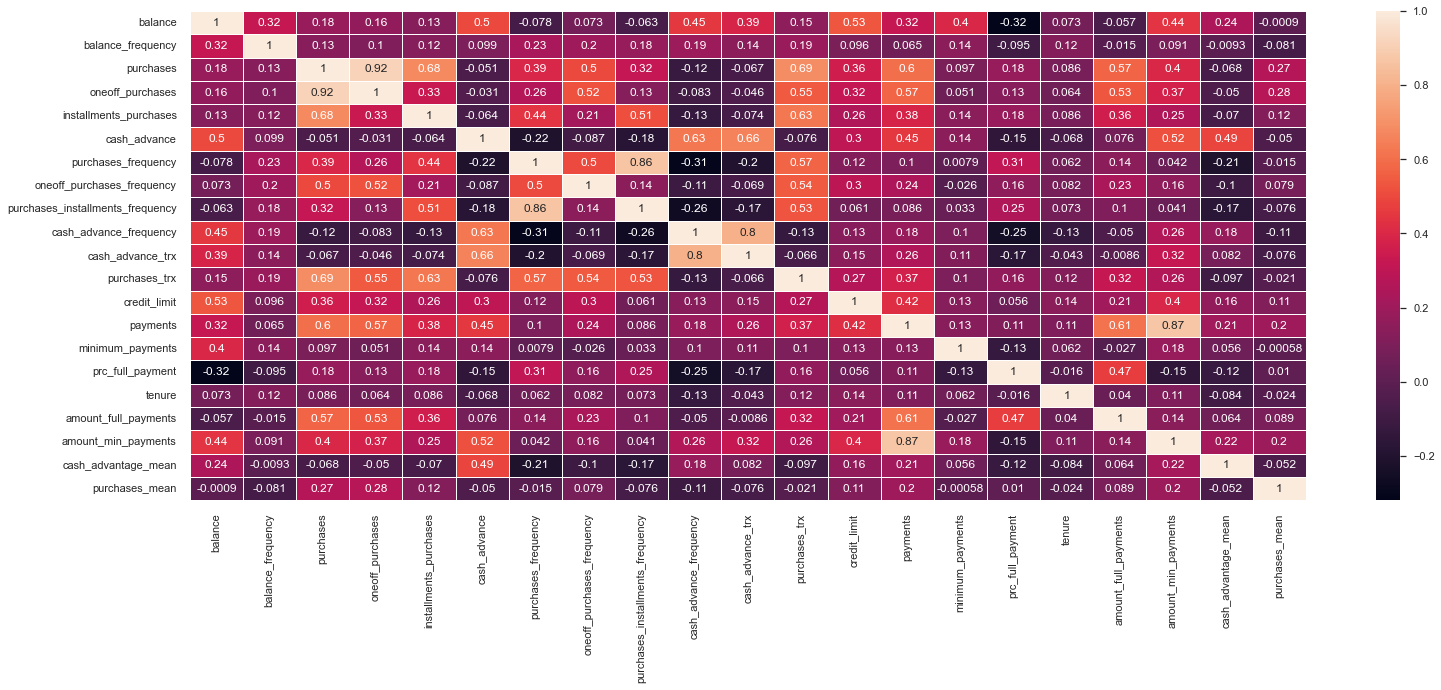

In [24]:
correlation = (df04.drop(columns = 'cust_id')).corr(method='pearson')
plt.figure(figsize=(25,9))
sns.heatmap(correlation, annot=True,linewidths=.5);

# Data Preparation

In [25]:
df05 = df04.copy()
df05.drop(['cust_id'], axis=1, inplace=True)

## Removing Outliers

In [26]:
# model definition
iso_model = en.IsolationForest(n_jobs = -1, n_estimators = 2500, contamination = 0.5)

#model fit
iso_model.fit (df05.values)

# predict
pred = iso_model.predict(df05.values)
pred_scores = -1 * iso_model.score_samples(df05.values)

# outlier detector
df05['outlier'] = pred_scores

In [27]:
threshold = 0.5
df05['outlier_flag'] = df05['outlier'].apply(lambda x: 1 if x > threshold else 0 )
df05 = df05.loc[df05['outlier_flag'] == 0, :]

In [28]:
print(f" Removidos {df04.shape[0] - df05.shape[0]} outliers, representando {round(((df04.shape[0] - df05.shape[0]) / df04.shape[0])*100,2)}% dos dados.")

 Removidos 713 outliers, representando 7.97% dos dados.


In [29]:
df05.drop(['outlier_flag','outlier' ], axis=1, inplace=True)

## Rescaling

In [242]:
df52 = df05.copy()

In [243]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer

In [245]:
mm = MinMaxScaler()
ss = pp.StandardScaler()
rs = RobustScaler()
mas = MaxAbsScaler()
nn = Normalizer()

cols = df52.columns

for columns in cols:
    df52[cols] = mas.fit_transform(df52[cols])


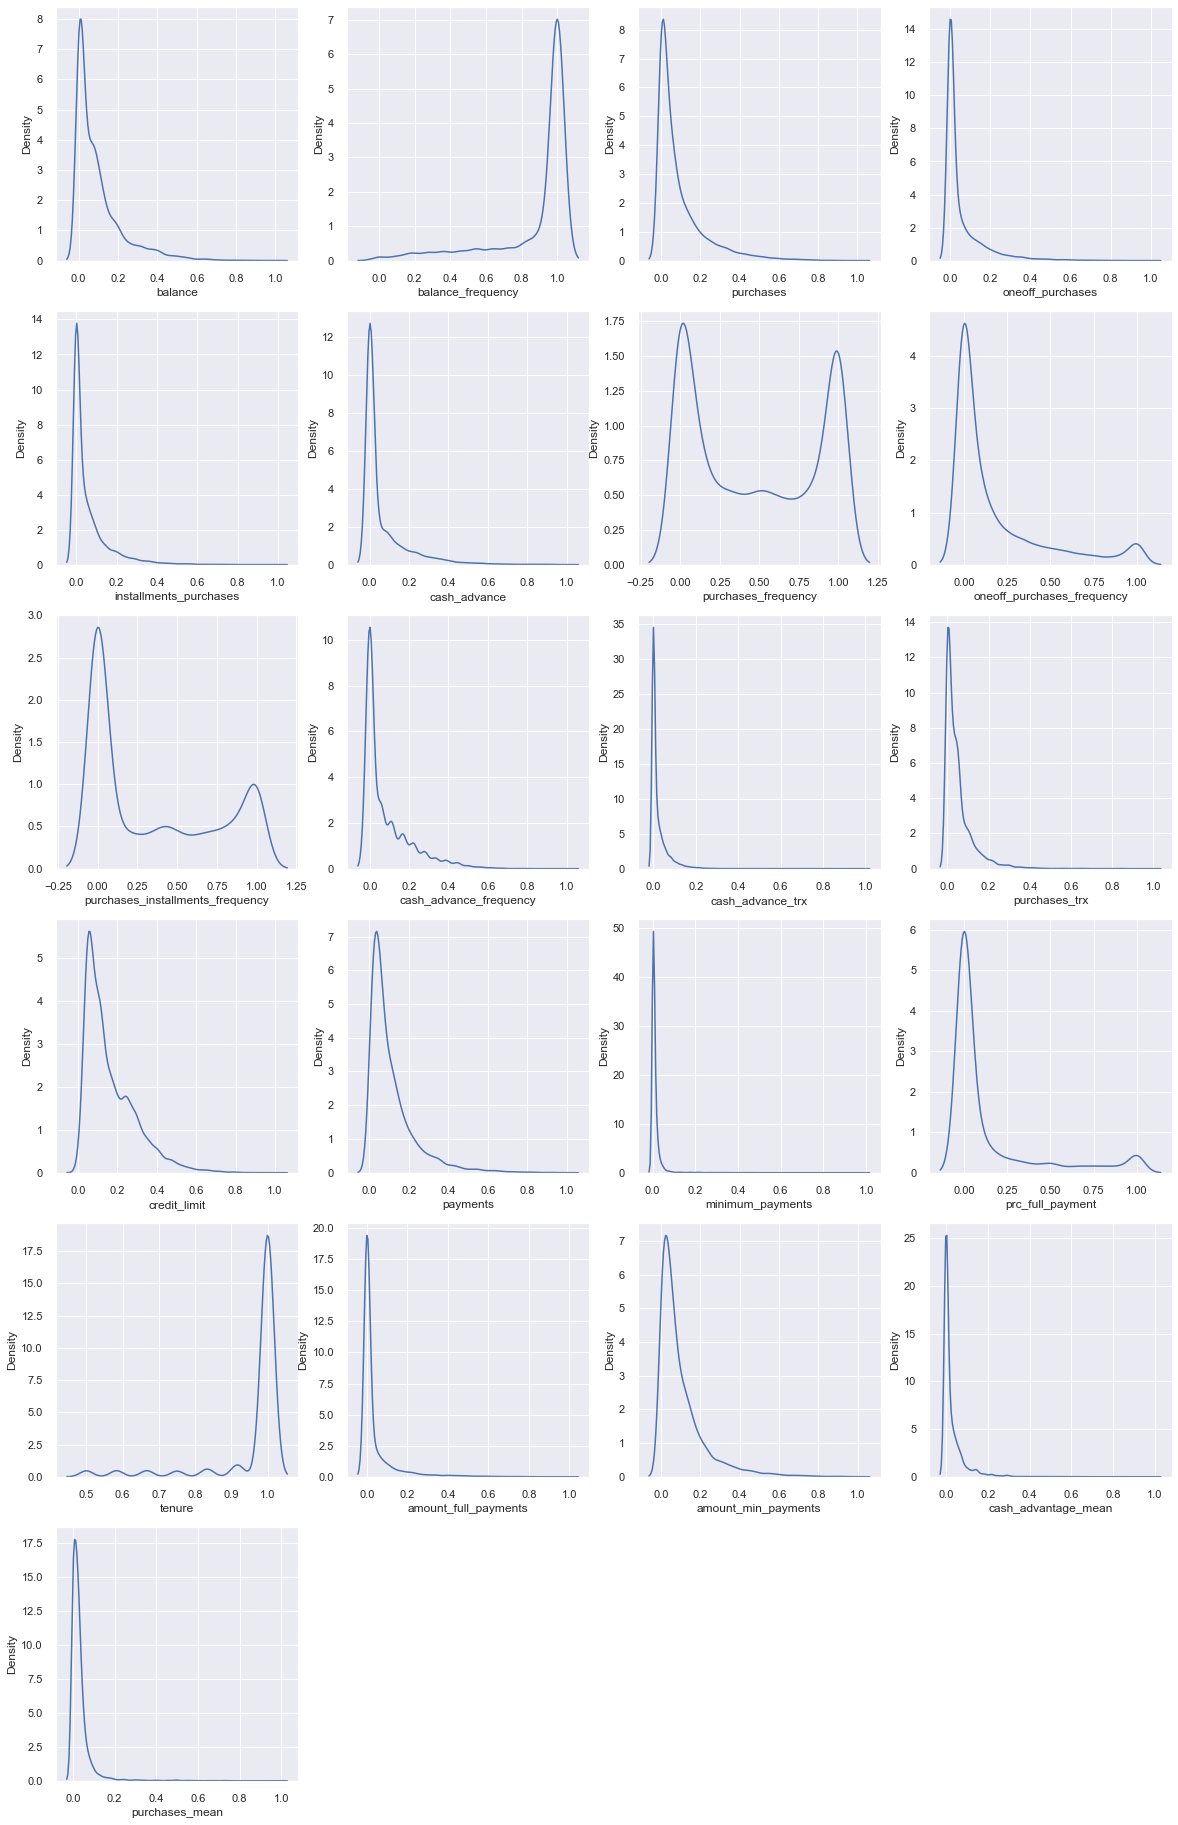

In [246]:
plt.figure(figsize=(20,55))
col = df52.columns
for i, col in enumerate(df52.columns):
    if df52[col].dtype != 'object':
        ax = plt.subplot(10, 4, i+1)
        sns.kdeplot(df52[col], ax=ax)
        plt.xlabel(col)
        
plt.show()

# Feature Selection

In [247]:
df06 = df52.copy()

In [248]:
df06.columns

Index(['balance', 'balance_frequency', 'purchases', 'oneoff_purchases',
       'installments_purchases', 'cash_advance', 'purchases_frequency',
       'oneoff_purchases_frequency', 'purchases_installments_frequency',
       'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx',
       'credit_limit', 'payments', 'minimum_payments', 'prc_full_payment',
       'tenure', 'amount_full_payments', 'amount_min_payments',
       'cash_advantage_mean', 'purchases_mean'],
      dtype='object')

In [249]:
remove_cols = ['balance','balance_frequency','credit_limit','purchases','purchases_frequency',
               'minimum_payments', 'prc_full_payment','tenure','payments','cash_advance_trx', 'purchases_trx']
df06.drop(remove_cols, axis=1, inplace=True)

In [250]:
df06.columns

Index(['oneoff_purchases', 'installments_purchases', 'cash_advance',
       'oneoff_purchases_frequency', 'purchases_installments_frequency',
       'cash_advance_frequency', 'amount_full_payments', 'amount_min_payments',
       'cash_advantage_mean', 'purchases_mean'],
      dtype='object')

In [251]:
df06.shape

(8237, 10)

# Hyperparameter Fine-Tunning

In [252]:
df07 = df06.copy()

# Model Training

In [253]:
df08 = df07.copy()

In [254]:
clusters = list(range(2, 11))

## K-Means clustering (K-Means)

In [255]:
silhouette_list = []
davies_list = []
calinski_list = []

for k in clusters:
    # model definition
    kmeans_model = cl.KMeans (n_clusters = k, random_state=42)

    # model training
    kmeans_model.fit(df08.values)

    # model predict
    labels_kmeans = kmeans_model.predict(df08.values)

    # model performance
    sil = mt.silhouette_score(df08, labels_kmeans)
    dav = mt.davies_bouldin_score(df08, labels_kmeans)
    cal = mt.calinski_harabasz_score(df08, labels_kmeans)
    silhouette_list.append(sil)
    davies_list.append(dav)
    calinski_list.append (cal)
    
    # metrics
    print ("For n_clusters = {0}: \nSS Score = {1}, DB Score = {2}, CH Score = {3} ".format(k, sil, dav, cal))
    print(100 * "-")

For n_clusters = 2: 
SS Score = 0.4392921787515726, DB Score = 0.9761985672681679, CH Score = 6609.346644717535 
----------------------------------------------------------------------------------------------------
For n_clusters = 3: 
SS Score = 0.46117993459570056, DB Score = 0.9414556824873287, CH Score = 6127.7556500071505 
----------------------------------------------------------------------------------------------------
For n_clusters = 4: 
SS Score = 0.4305101420841241, DB Score = 0.995209050613338, CH Score = 5307.605200067253 
----------------------------------------------------------------------------------------------------
For n_clusters = 5: 
SS Score = 0.35285383794974357, DB Score = 1.0233025277188659, CH Score = 4895.231440695876 
----------------------------------------------------------------------------------------------------
For n_clusters = 6: 
SS Score = 0.3294888214652867, DB Score = 1.1097439867768382, CH Score = 4735.44128306021 
------------------------------

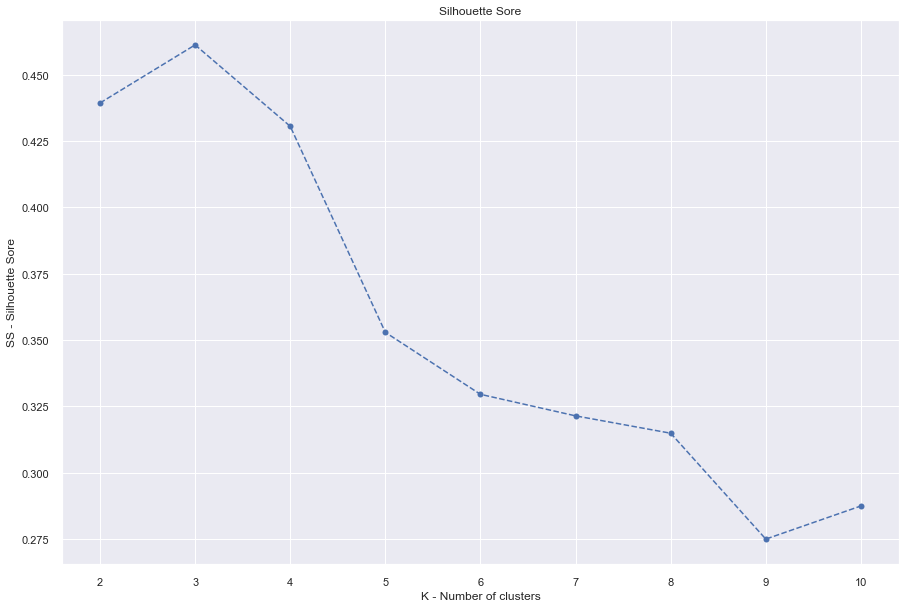

In [256]:
plt.figure( figsize=(15,10))
plt.plot( clusters, silhouette_list, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('K - Number of clusters')
plt.ylabel( 'SS - Silhouette Sore')
plt.title( 'Silhouette Sore');

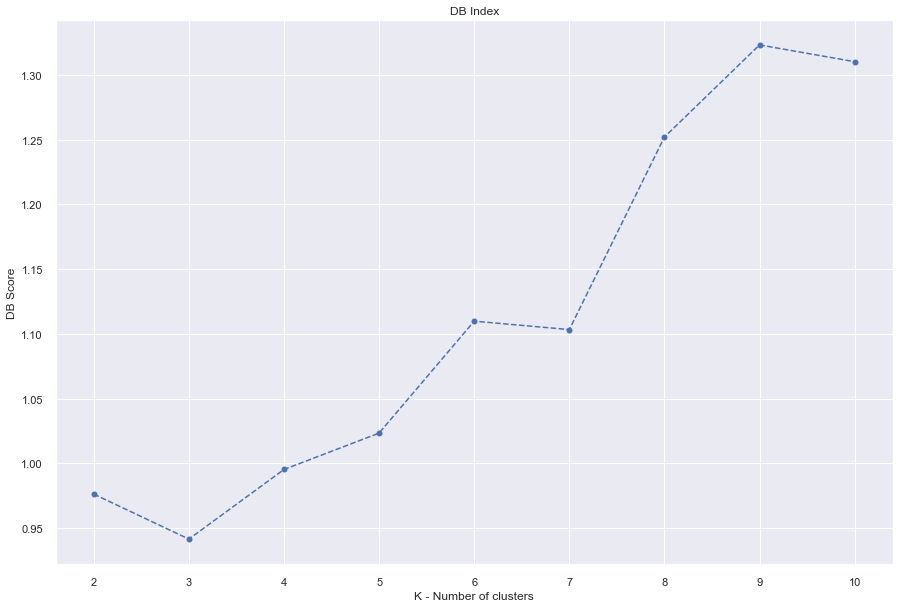

In [257]:
plt.figure( figsize=(15, 10 ))
plt.plot( clusters, davies_list, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('K - Number of clusters')
plt.ylabel( 'DB Score')
plt.title( 'DB Index');

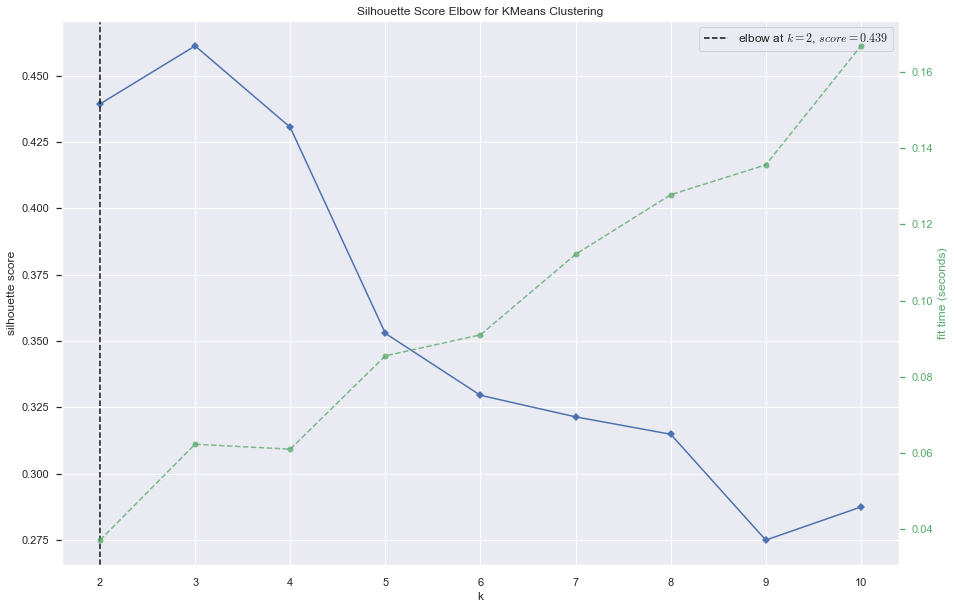

In [291]:
plt.figure(figsize=(15,10))
distortion_visualizer = KElbowVisualizer(kmeans_model, k=clusters, metric ='silhouette')
distortion_visualizer.fit(df08.values)       
distortion_visualizer.show();

## Gaussian Mixture Model (GMM)

In [230]:
silhouette_list = []
davies_list = []
calinski_score = []

for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components = k)

    # model training
    gmm_model.fit (df08.values)

    # model prediction
    labels_gmm = gmm_model.predict (df08.values)

    # model performance
    sil = mt.silhouette_score(df08.values, labels_gmm)
    dav = mt.davies_bouldin_score(df08.values, labels_gmm)
    silhouette_list.append(sil)
    davies_list.append(dav)
           
    # metrics
    print ("For n_clusters = {0}: \nSS Score = {1}, DB Score = {2}, CH Score = {3} ".format(k, sil, dav, cal))
    print(100 * "-")

For n_clusters = 2: 
SS Score = 0.28466370169920474, DB Score = 1.2131406564702119, CH Score = 3509.2248784452568 
----------------------------------------------------------------------------------------------------
For n_clusters = 3: 
SS Score = 0.12274603380308043, DB Score = 3.073286253314695, CH Score = 3509.2248784452568 
----------------------------------------------------------------------------------------------------
For n_clusters = 4: 
SS Score = 0.10975587123458531, DB Score = 3.733783728899298, CH Score = 3509.2248784452568 
----------------------------------------------------------------------------------------------------
For n_clusters = 5: 
SS Score = 0.04797922105937958, DB Score = 2.7023228767452308, CH Score = 3509.2248784452568 
----------------------------------------------------------------------------------------------------
For n_clusters = 6: 
SS Score = 0.05095655156066178, DB Score = 2.5312628777190276, CH Score = 3509.2248784452568 
-----------------------

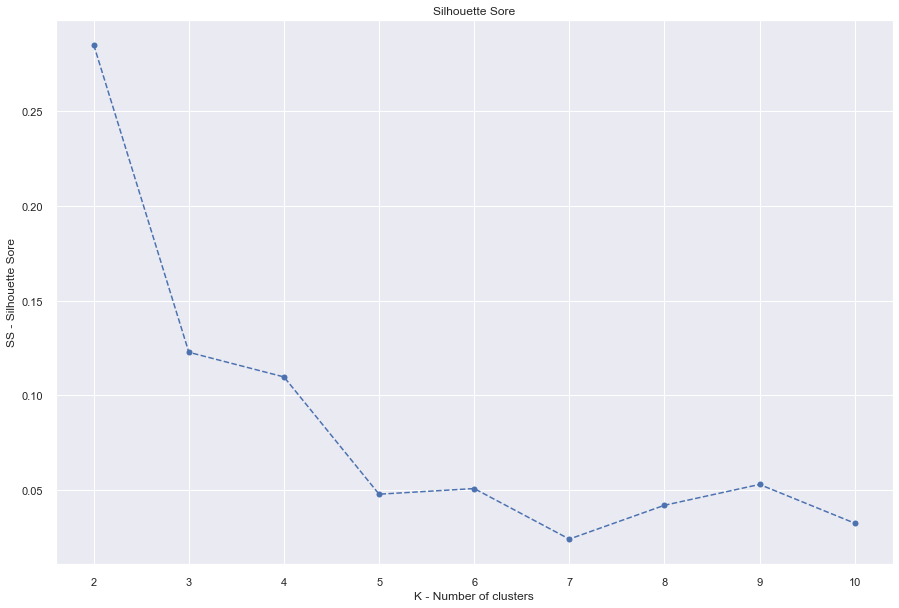

In [231]:
plt.figure( figsize=(15, 10 ))
plt.plot( clusters, silhouette_list, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('K - Number of clusters')
plt.ylabel( 'SS - Silhouette Sore')
plt.title( 'Silhouette Sore');

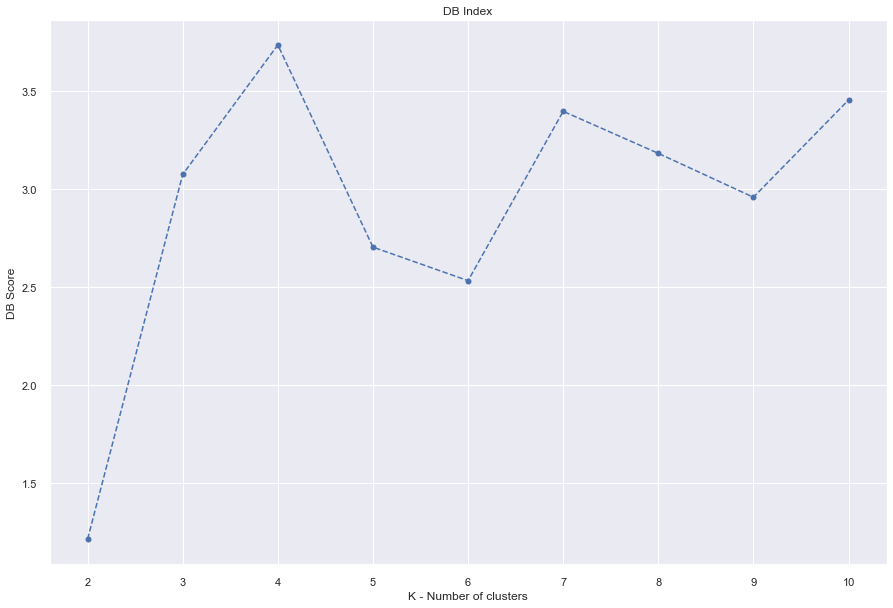

In [232]:
plt.figure( figsize=(15, 10 ))
plt.plot( clusters, davies_list, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('K - Number of clusters')
plt.ylabel( 'DB Score')
plt.title( 'DB Index');

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

In [49]:
neigh = NearestNeighbors()
nbrs = neigh.fit(df08)
distances, indices = nbrs.kneighbors(df08)

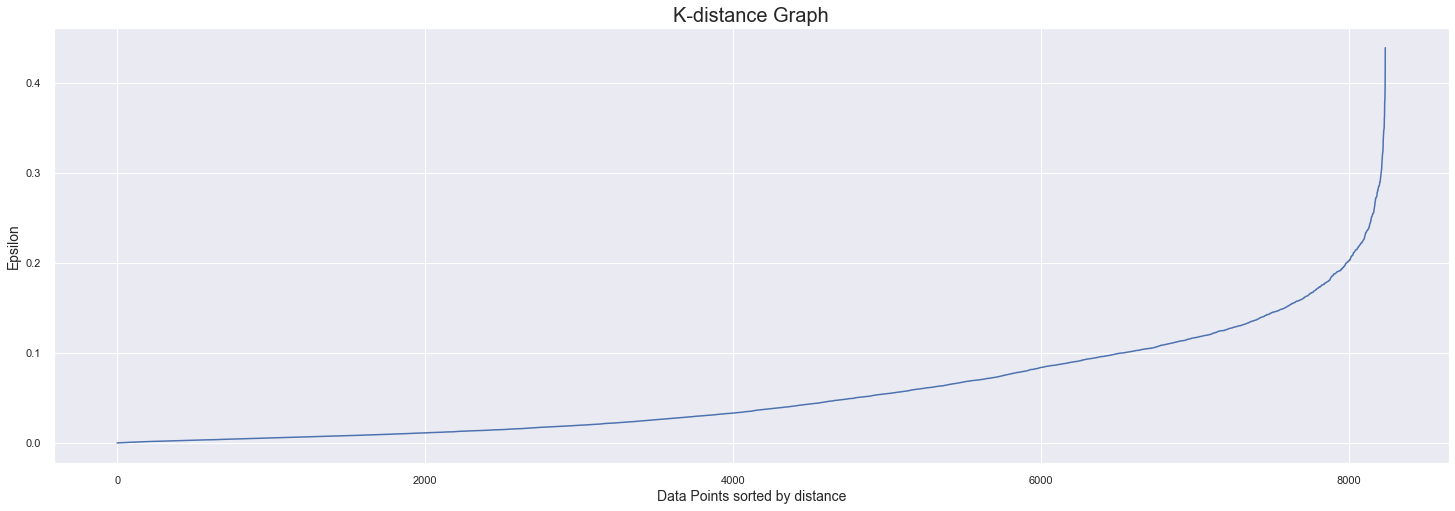

In [50]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(25,8))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [51]:
eps = 0.25
min_samples = 1000

# model definition
dbscan_model = cl.DBSCAN (eps=eps, min_samples=min_samples)

# model training & predict
labels = dbscan_model.fit_predict (df08)

sil = mt.silhouette_score ( df08.values, labels,  metric =  'euclidean')
print('Silhouette Score: {}'.format(sil))
print('Number of Clusters: {}'. format(len( unique(labels))))
print(unique(labels))

Silhouette Score: 0.348457761775047
Number of Clusters: 3
[-1  0  1]


## hierarchy

In [66]:
import scipy.cluster.hierarchy as shc

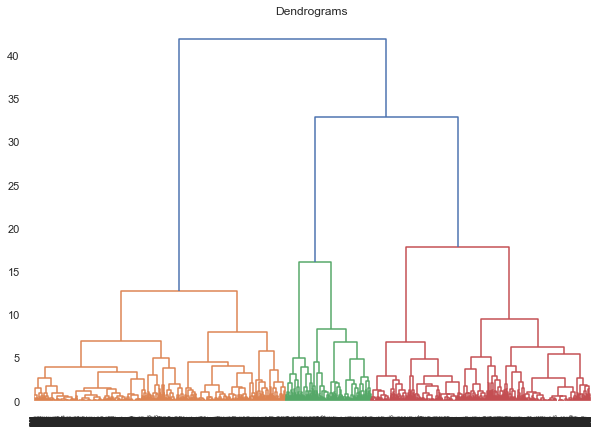

In [67]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df08, method='ward'))
plt.axhline(y=120, color='r', linestyle='--');

In [68]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df08)

array([1, 1, 0, ..., 3, 1, 0], dtype=int64)

# Model Training

In [259]:
k = 4

# model definition
kmeans_model = cl.KMeans (n_clusters = k, init='k-means++',random_state=42,n_init=10)

# model training
kmeans_model.fit(df08.values)

# model predict
labels_KMeans = kmeans_model.predict(df08.values)

## Cluster Validation

In [260]:
## SS (Silhoutte Score) 
print('SS - Silhouette Score KMeans            : {}'.format(mt.silhouette_score(df08, labels_KMeans, metric='euclidean')))

## WSS (within Cluster sum of square)
print('WSS - within Cluster Sum of Square Value: {}'. format(kmeans_model.inertia_))

SS - Silhouette Score KMeans            : 0.4305101420841241
WSS - within Cluster Sum of Square Value: 866.5574973546983


## Cluster Analysis

### Cluster diagnoses

In [261]:
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']

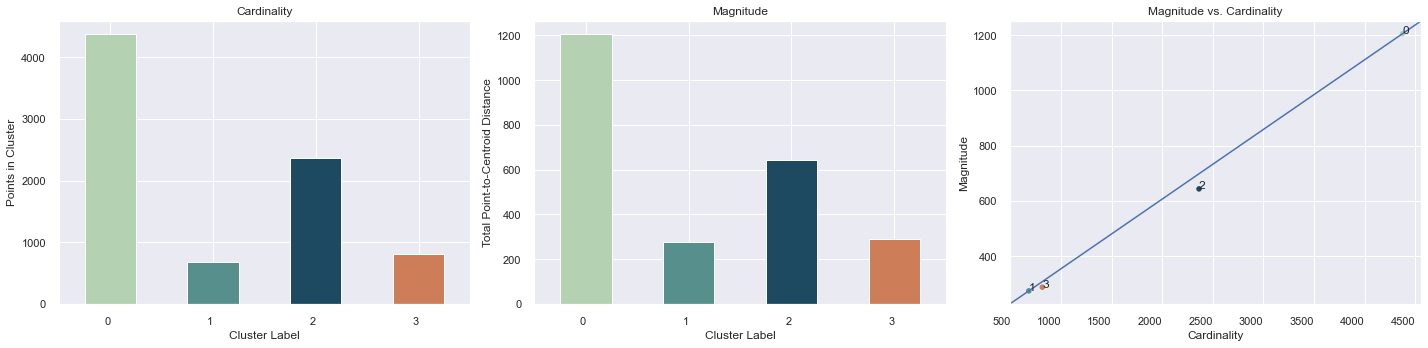

In [262]:
from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))

plot_cluster_cardinality(kmeans_model.labels_,
                         ax=ax1,
                         title="Cardinality",
                         color=cluster_colors
                        )
plot_cluster_magnitude(df08.values,
                       kmeans_model.labels_,
                       kmeans_model.cluster_centers_,
                       euclidean,
                       ax=ax2,
                       title="Magnitude",
                       color=cluster_colors
                      )
plot_magnitude_vs_cardinality(df08.values,
                              kmeans_model.labels_,
                              kmeans_model.cluster_centers_,
                              euclidean,
                              color=cluster_colors[0:kmeans_model.n_clusters],
                              ax=ax3, 
                              title="Magnitude vs. Cardinality")

fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

### Silhouette Analysis

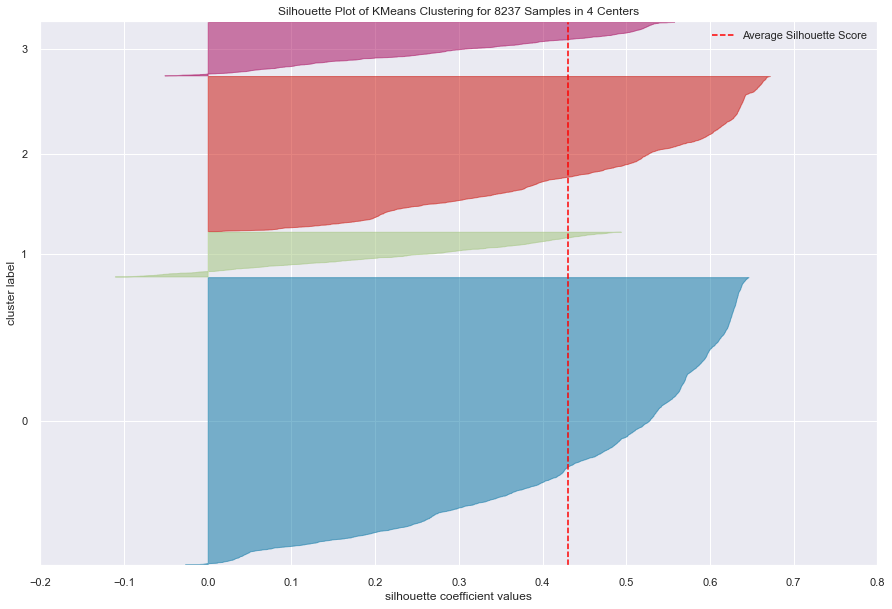

In [263]:
visualizer = SilhouetteVisualizer(kmeans_model, colors='yellowbrick')
plt.figure(figsize=(15,10))
visualizer.fit(df08.values)
visualizer.show();

### Cluster Profile

In [287]:
df10 = df05.copy()
df10.drop(['minimum_payments', 'prc_full_payment','cash_advantage_mean', 'purchases_mean'], axis=1, inplace=True)

In [288]:
cols = df10.columns
for columns in cols:
    df10[cols] = ss.fit_transform(df10[cols])

In [289]:
df10['clusters'] = labels_KMeans

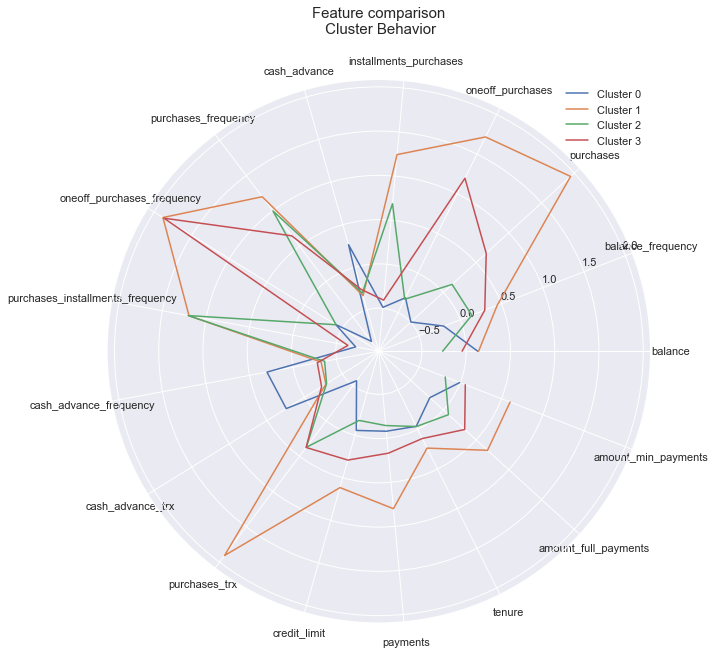

In [290]:
spider_plot(df10, 'Cluster Behavior')

In [274]:
df11 = df05.copy()
df11['clusters'] = labels_KMeans

In [86]:
cols = ['balance', 'balance_frequency', 'purchases', 'oneoff_purchases',
       'installments_purchases', 'cash_advance', 'purchases_frequency',
       'oneoff_purchases_frequency', 'purchases_installments_frequency',
       'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx',
       'credit_limit', 'payments', 'minimum_payments', 'prc_full_payment',
       'tenure', 'amount_full_payments', 'amount_min_payments',
       'cash_advantage_mean', 'purchases_mean']

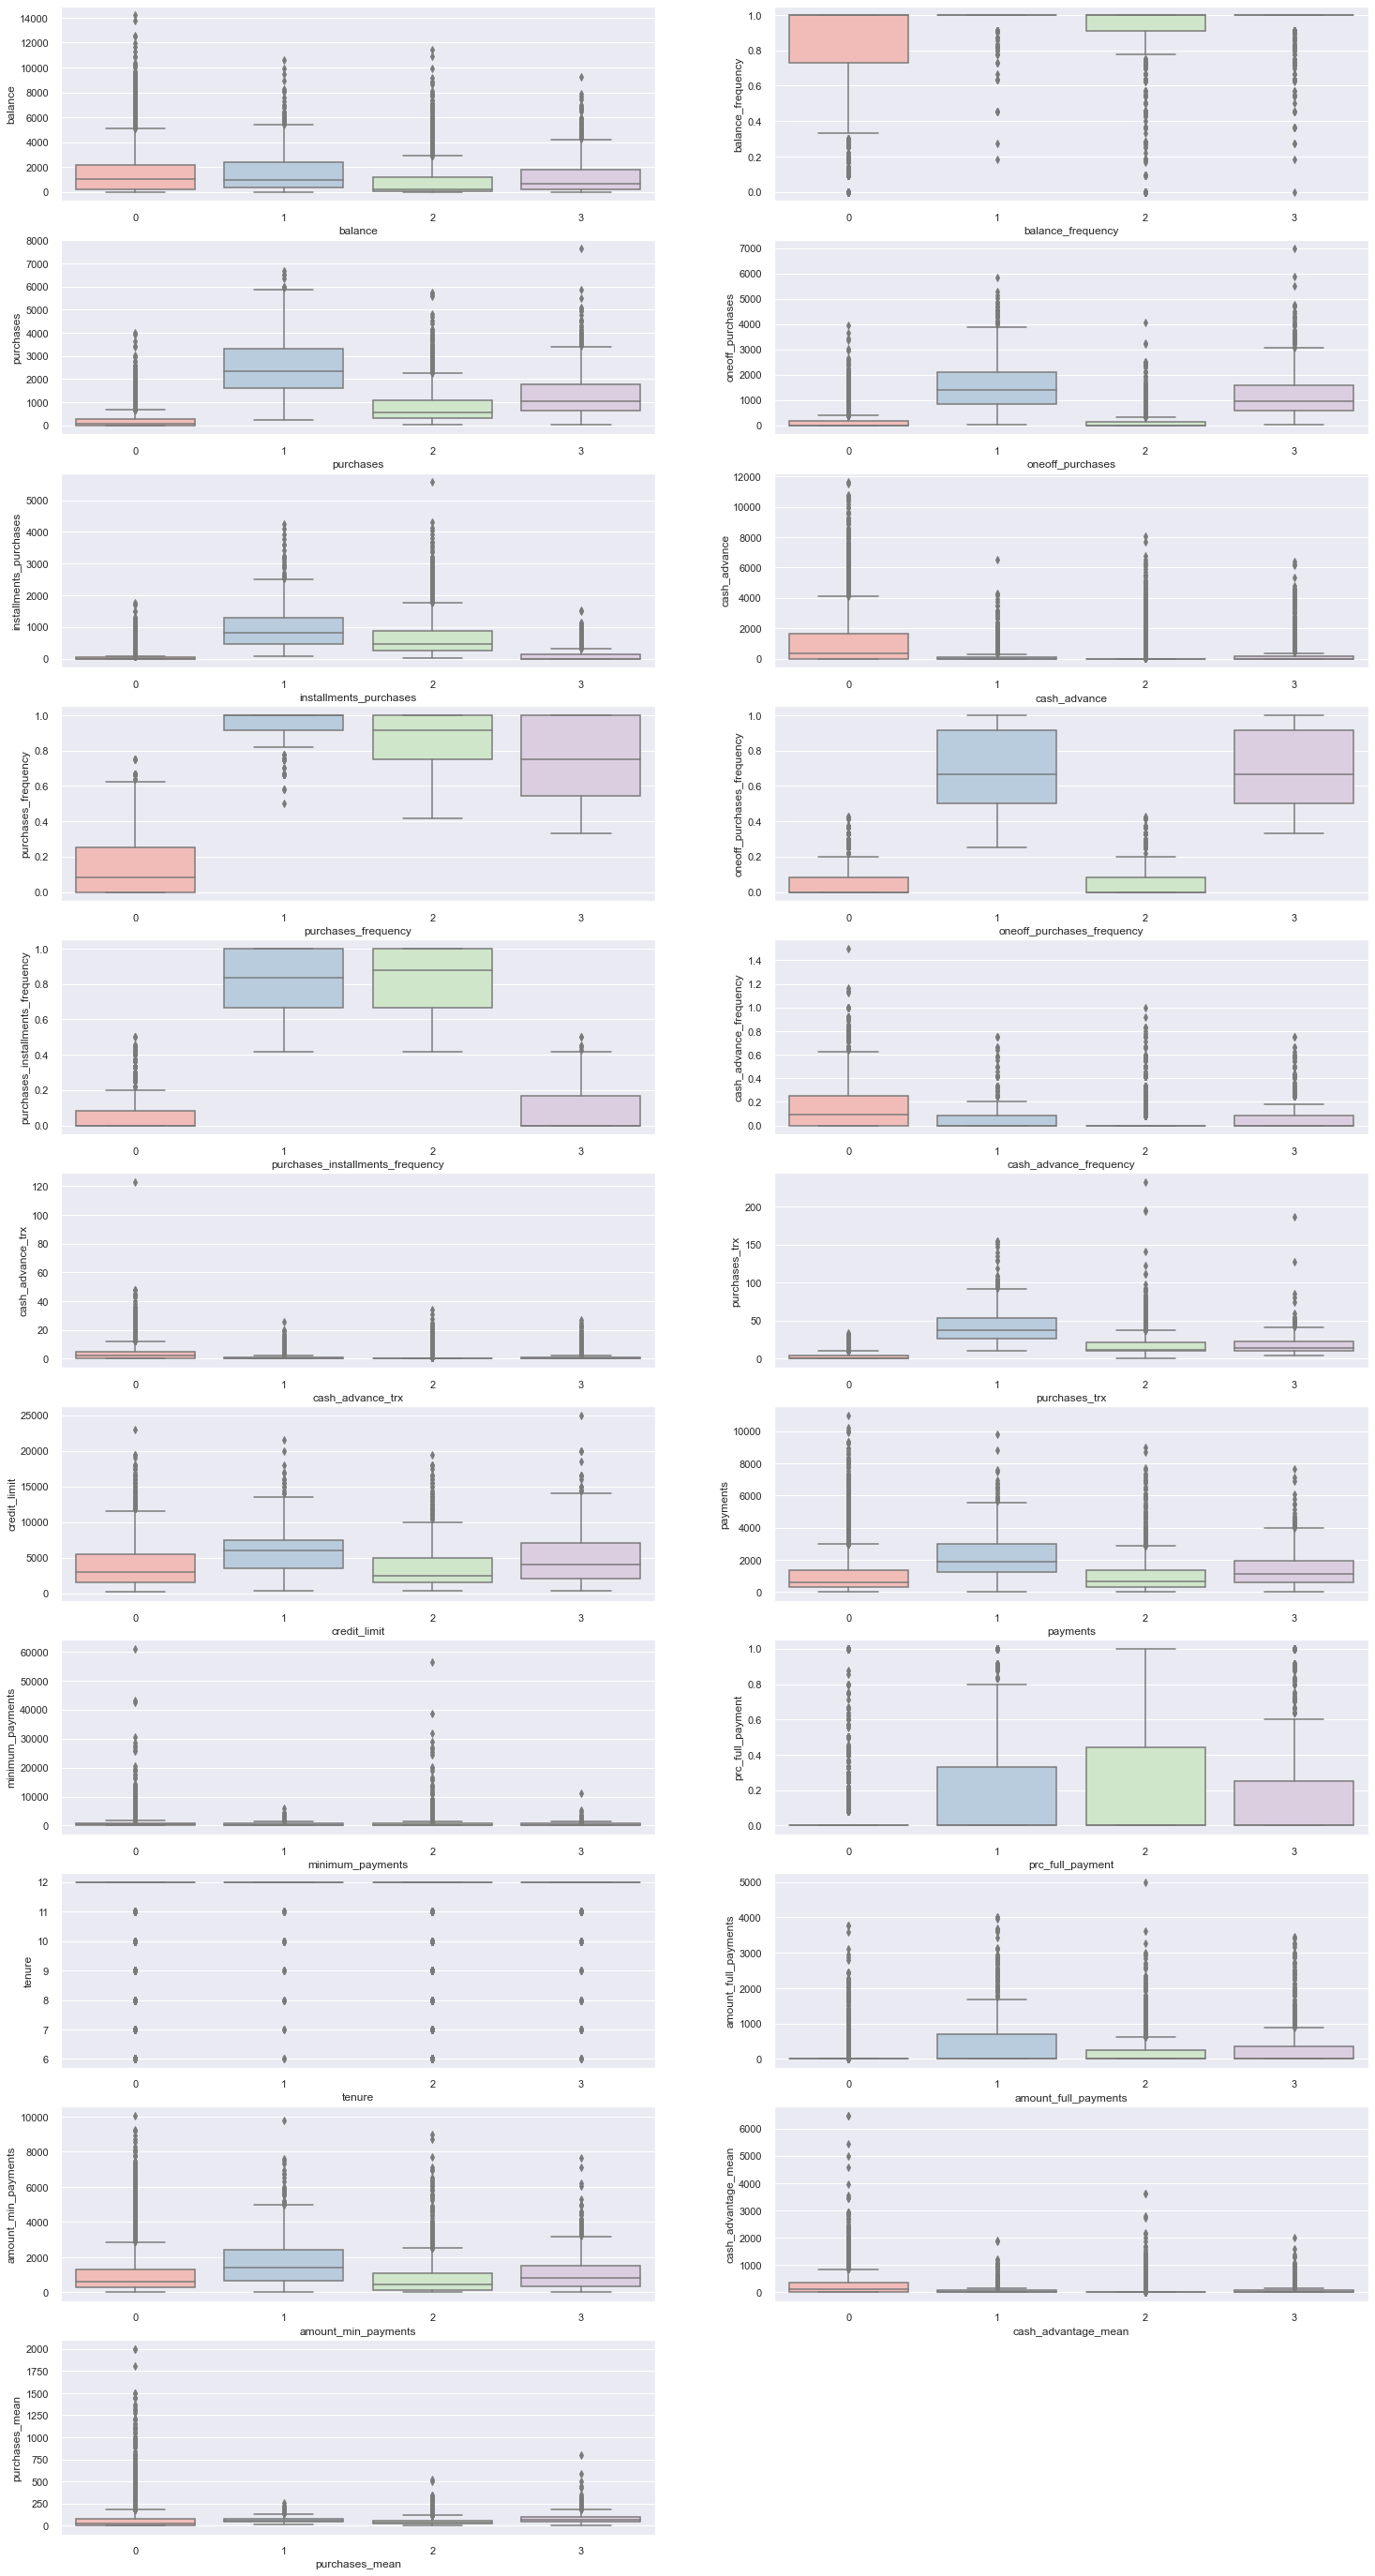

In [87]:
plt.figure(figsize=(25,100))
for i, col in enumerate(cols):
    if df11[col].dtype != 'object':
        ax = plt.subplot(22, 2, i+1)
        #sns.kdeplot(df03[col], ax=ax)
        sns.boxplot(x = 'clusters', y = col, data = df11 ,palette='Pastel1');
        plt.xlabel(col)
plt.show()